### Setup

In [1]:
import sys
import csv
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

%matplotlib inline

In [2]:
print(sys.version)
print('numpy:',np.__version__)
print('pandas:',pd.__version__)
print('sklearn:',sklearn.__version__)
print('seaborn:',sns.__version__)
print('nltk:',nltk.__version__)
print('re:',re.__version__)

3.8.8 (default, Feb 24 2021, 13:46:16) 
[Clang 10.0.0 ]
numpy: 1.19.2
pandas: 1.2.3
sklearn: 0.24.1
seaborn: 0.11.1
nltk: 3.5
re: 2.2.1


In [3]:
df = pd.read_csv('./Restaurant_Reviews.tsv', delimiter = '\t')
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
4,The selection on the menu was great and so were the prices.,1


In [4]:
print('Total number of reviews = %d'%(df.shape[0]))
print('Positive reviews = %d'%(df["Liked"]==1).sum())
print('Negative reviews = %d'%(df["Liked"]==0).sum())
print("Any empty records?")
print(df.isnull().sum())

Total number of reviews = 1000
Positive reviews = 500
Negative reviews = 500
Any empty records?
Review    0
Liked     0
dtype: int64


### Exploring customer reviews

#### Stop words

Stop words are defined as the most common words in a language, e.g., the, is, a, as, such, etc. Stop word removal can be thought of as a form of feature selection. In nltk package 'not' is considered a stop word. 
In sentiment analysis, the context of the text is important which mean the negation can indicate whether a review is a positive or negative one, e.g., food was good vs. food was not good. Here, I manually exclude negation from stop word list.

In [5]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords = set(stopwords)
negation_words = ["aren't",'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'don',"don't",'hadn',"hadn't",'hasn',"hasn't",\
'haven',"haven't",'isn',"isn't",'mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'no','nor','not',\
'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"]
stopwords_v2 = [w for w in stopwords if w not in negation_words]


[nltk_data] Downloading package stopwords to /Users/isra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Lemmatisation

``In linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.`` Wikipedia

In [6]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/isra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
## preprocess review text, get rid of special chars, convert to lower, remove stop words and apply lemmatizer
def preprocess(review):
    #review = review.replace("n't"," not")
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = re.sub('\s+',' ',review)
    review = review.replace("\n","")
    review = review.lower()
    review = review.split()
    review = [word for word in review if word not in stopwords_v2]
    review = [lemmatizer.lemmatize(word) for word in review]
    return ' '.join(review)

In [8]:
from wordcloud import WordCloud

def plot_wordcloud(data):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 43
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

### Plot word cloud for positive and negative reviews

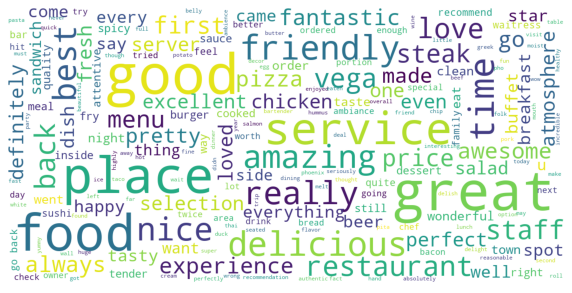

In [9]:
pos_df = df.loc[df["Liked"]==1]
pos_df['Review'] = pos_df['Review'].apply(preprocess)
pos_reviews = pos_df['Review'].values
pos_reviews = ' '.join(pos_reviews)
plot_wordcloud(pos_reviews)

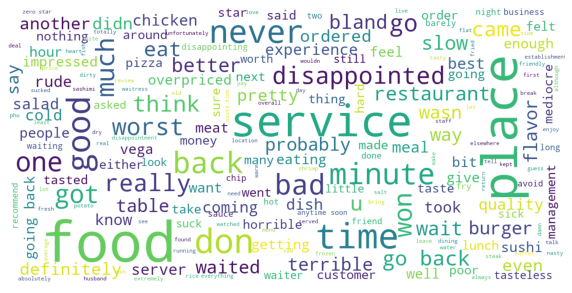

In [10]:
neg_df = df.loc[df["Liked"]==0]
neg_df['Review'] = neg_df['Review'].apply(preprocess)
neg_reviews = neg_df['Review'].values
neg_reviews = ' '.join(neg_reviews)
plot_wordcloud(neg_reviews)

### Data preparation

In [11]:
df['cleaned_review'] = df['Review'].apply(preprocess)
df[['Review','cleaned_review']].head(5)

,Review,cleaned_review
0,Wow... Loved this place.,wow loved place
1,Crust is not good.,crust not good
2,Not tasty and the texture was just nasty.,not tasty texture nasty
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,stopped late may bank holiday rick steve recommendation loved
4,The selection on the menu was great and so were the prices.,selection menu great price


#### Convert a collection of text documents to a matrix of token counts

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 2000) # upper limit for featuer size, nlater will be set to the vocabulary size found in the input data.

X = vectorizer.fit_transform(df['cleaned_review'].values).toarray()
y = df["Liked"].values

#### Split train and test sets

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 43)

In [ ]:
print('X_train.shape =',X_train.shape,',y_train.shape =',y_train.shape[0])
print('X_test.shape =',X_test.shape,',y_test.shape =',y_test.shape[0])

### Train Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 43)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=43)

In [15]:
y_pred = clf.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


acc_score = accuracy_score(y_test, y_pred)*100
print('accuracy_score = %.2f%%\n'%acc_score)
print(classification_report(y_test, y_pred))

accuracy_score = 86.50%

              precision    recall  f1-score   support

           0       0.81      0.94      0.87        97
           1       0.93      0.80      0.86       103

    accuracy                           0.86       200
   macro avg       0.87      0.87      0.86       200
weighted avg       0.87      0.86      0.86       200



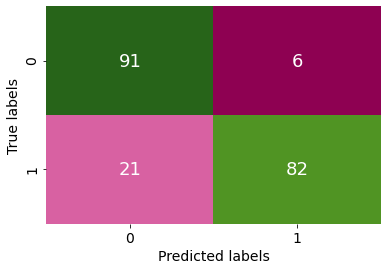

In [17]:
cm = confusion_matrix(y_test,y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax,cmap='PiYG',cbar=False,annot_kws={"fontsize":18});  #annot=True to annotate cells

ax.set_xlabel('Predicted labels',size=14)
ax.set_ylabel('True labels',size=14)
ax.xaxis.set_ticklabels(['0', '1'], size=14)
ax.yaxis.set_ticklabels(['0', '1'],size=14);

In [21]:
## I made up some data to test
test_reviews = ["Highly recommend!!", "Average service, nothing special", "good food but slow service",
               "Not a happy customer","Lukewarm food","I recommend for a quick lunch","good"]

for rev in test_reviews:
    rev = preprocess(rev)
    test_vec = vectorizer.transform([rev])
    print(rev,'-->',clf.predict(test_vec)[0])

highly recommend --> 1
average service nothing special --> 0
good food slow service --> 1
not happy customer --> 0
lukewarm food --> 0
recommend quick lunch --> 0
good --> 1
